# Event Display for primary Geant4 events

Most of the code taken from Pietro DiGangi's event display code for XENON1T and slightly modified. The original code can be found here: https://github.com/XENON1T/MCAnalysisScripts/tree/master/G4EventDisplay

### Imports

In [1]:
from init import *
from networkx_additional import *
from rootIO import *

### Single event selection and event scan
+ The function event_df extracts information of a specific event into a dataframe. It returns the event dataframe and the information of the primary particle in a list [xp_pri, yp_pri, zp_pri, e_pri].
+ events_scan displays the entire event dataframe in HTML table format.

In [2]:
def event_df(event):
    '''Returns the event dataframe and the information of the primary particle 
    in a list [xp_pri, yp_pri, zp_pri, e_pri]. The argument is a row
    of the main G4 dataframe, corresponding to a specific eventid.'''
    
    index = event.index[0]
    
    #--- select columns to extract (you can drop or add more variables here) ---
    columns = ['trackid',
               'type',
               'xp',
               'yp',
               'r2p',
               'zp',
               'parentid',
               'parenttype',
               'creaproc',
               'ed',
               'edproc',
               'time'
              ]
   
    trackid=[]
    type=[]
    xp=[]
    yp=[]
    r2p=[]
    zp=[]
    parentid=[]
    parenttype=[]
    creaproc=[]
    ed=[]
    edproc=[]
    time=[]
    table = [trackid,type,xp,yp,r2p,zp,parentid,parenttype,creaproc,ed,edproc,time]
    
    #--- extract columns from main G4 dataframe ---
    for i in range(0,len(columns)):
        table[i] = event[columns[i]][index]
        
    #--- make the event dataframe ---
    df = pd.DataFrame(table)
    df = df.transpose()
    df.columns = columns
    
    #--- primary particle information to a list ---
    x = event.xp_pri[index]
    y = event.yp_pri[index]
    z = event.zp_pri[index]
    e = event.e_pri[index]
    type = event.type_pri[index]
    primary = [x,y,z,e,type]
    
    return df, primary  

def event_scan(df, eventid):
    '''Print the event dataframe (analogous to Scan of ROOT tree) in table format'''
    event, primary = event_df(df[df.eventid==eventid])
    display(HTML(event.to_html()))

### Plotting daughter-parent hierarchy
The function draw_hierarchy builds a networkx graph to plot the particles contained in the event with hierarchic structure starting from the primary particle.

It show particles' trackid and type and labels the edge connecting daughter-parent with the physical process occurred (creaproc).

In some events one or more parent particles can be missing from the output G4 tree (because it never entered a sensitive volume, but a doughter did). In this case the hierarchic dependency is broken. Only branches with full dependency up to the primary particle are shown in the graph. A warning message for particles with broken branch is shown.

origin argument: 
It specifies the head of the hierarchy. It is 1 (primary particle) by default. If you want to better visualize the branch from a specific particle of the event, you can pass the trackid of such particle as origin. This will still show as a first branch all the backward chain of particles (you should ignore that). There should be a way to take out that first backward branch... added to the todo list :)

In [3]:
#======================= Utilities for hierarchy graph ============================= 

def get_daughters_trackid(event, parentids):
    '''Returns a trackid list of daughters of a set of parent particles.'''
    event = event[event.parentid.isin(parentids)]
    tracks = list(set(event.trackid)) # trackids present in the event    
    tracks.sort() # sort trackids
    return tracks

def get_parentids(event):
    '''Returns a trackid list of all the parent particles in the event.'''
    tracks = list(set(event.parentid))    
    tracks.sort() # sort trackids
    return tracks


def particles_steps(event):
    '''
    Groups particles in daughter production steps. 
    Returns number of steps, 
    a coefficient to increase hierarchy graph dimensions based on multiplicity of daughter productions,
    the list of particles with valid parent dependency
    '''
 
    ids = get_daughters_trackid(event,parentids=[1]) # get daughters of primary particle  
    particles_by_step=[] # divide particles in hierarchic steps
    particles_by_step.append(ids)    
    all_particles = ids # store id of particles displayed in hierarchy graph
   
    #--- Loop over steps as long as a daughter particle is produced ---
    i=1
    while len(ids)>0:
        ids = get_daughters_trackid(event,parentids = ids)
        if len(ids)>0:
            particles_by_step.append(ids)
            all_particles = all_particles + ids
            i = i+1            
    #print('particles by step:', particles_by_step)
    
    ids = []
    nsteps = i
    multiplicity = 1
    
    step_max = 0
    multiplicity_max = 1
   
    #--- Associate daughter particles to their parent ---
    for n in (range(0,nsteps)):
        set_ids = particles_by_step[n]        
        particles = event[event.trackid.isin(set_ids)]
        parent_ids = get_parentids(particles)
        multiplicity = len(parent_ids) * multiplicity        
        list_=[]
        # collect by parentid
        for parent in parent_ids:
            daughters = get_daughters_trackid(particles,[parent]) # set of daughters of this parent
            list_.append([parent,daughters])
            
            if len(daughters)>=multiplicity_max:
                multiplicity_max=len(daughters)
                step_max = n+2
        
        ids.append(list_)
        
    coefficient = multiplicity_max*step_max
    #print(multiplicity_max, step_max)
        
    return nsteps+1, coefficient, all_particles


#======================= Main function to plot hierarchy graph ============================= 

def draw_hierarchy(df, eventid, particles=[], origin=1):
    '''origin is the top of the hierarchy'''
    event, primary = event_df(df[df.eventid==eventid])
    if len(particles)>0:
        event = event[event.type.isin(particles)]
        
    event = event.sort_values(by=['trackid']) # sort dataframe by trackid
    
    #--- Get info about daughter production steps ---
    nsteps, coeff, all_particles = particles_steps(event)    
    all_particles.append(0)
    all_particles.append(1)
    #print('particles:', all_particles)
    
    #--- Particles without parent + particles not saved in G4 output which produced daughters
    nn = event[~event.trackid.isin(all_particles)]
    missing_parent = list(set(nn.trackid))
    unknowns = set(missing_parent + list(set(nn.parentid)))
    #print('sons of a bitch:', unknowns)
    
   
    #--- figure dimensions ---
    fig, ax = plt.subplots()
    fig.set_figwidth(10+coeff*1.)
    fig.set_figheight(nsteps*3)
    

    #--- graph ---
    g = nx_from_pandas_dataframe(event, source='trackid', target='parentid') 
    #print('nodes:', g.nodes())
    #print('edges:', g.edges())
    
    try: g.remove_node(0) # remove first node for better visualization
    except: pass

    #--- Remove nodes for particles with missing parent ---
    for track in unknowns:
        try: g.remove_node(track)
        except: pass
    
    #print('After removing nodes...')   
    #print('nodes:', g.nodes())
    #print('edges:', g.edges())


    #--- specific attributes for edges (creaproc) ---
    edges = list(g.edges())
    labels_edges = {}

    for i in range(0,len(edges)):
        trackid = edges[i][1]
        particle = event[event.trackid==trackid] # Select steps of a specific particle
        try: 
            creaproc = particle.creaproc[particle.index[0]]
        except:
            creaproc = 'unknown'
        labels_edges[edges[i]] = creaproc

        
    #--- specific attributes for nodes (id, type, color) ---    
    nodes = list(g.nodes())    
    labels_nodes = {}
    node_shape = []
    node_alpha = []
    colors = []
    cmap = cm.nipy_spectral
    for i in range(0,len(nodes)):
        trackid=nodes[i]         
        particle = event[event.trackid==trackid] # Select steps of a specific particle
        try: 
            type = particle.type[particle.index[0]] # Get type of the particle
        except:
            type = '?'
        #type = particle.type[particle.index[0]] # Get type of the particle
        #marker, alpha = get_marker_type_tree(type) # Get marker and alpha for the particle   
        #node_shape.append(marker)
        #node_alpha.append(alpha)
        colors.append(cmap(i/len(nodes)))
        labels_nodes[nodes[i]] = type
        
        labels_nodes[1] = primary[4][0] # (re)assign particle type to primary particle (if missing in G4 output tree)
    labels_nodes = OrderedDict(sorted(labels_nodes.items()))
        
    #--- Defined hierarchic positions ---
    pos = nx_hierarchy_pos(g,origin) 
   
    #print('edges:', g.edges())
    #print('labels-edges:', labels_edges)
    #print('nodes:', g.nodes())
    #print('labels-nodes:', labels_nodes)
    #print('colors:', colors)
    
    #--- Draw graph ---
    nx.draw(g, pos=pos, node_size=1000, with_labels=True, node_color=colors,
            font_color='white', font_size=14, edge_color='gray', width=2, style='solid')
    
    #--- Draw edge labels ---
    nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels_edges)
    #--- Draw additional nodes labels ---
    nx_draw_labels(g, pos=pos, labels=labels_nodes, font_color=colors, font_size=14, yoffset=0.033)

    plt.show()
        
    #--- Warning message about missing particles ---
    if len(missing_parent)>0:
        print('>>> Warning <<<\nSome particles are not displayed in the hierarchy graph because their parent is not saved in the output G4 tree.')
        print('Particles not shown in the hierarchy graph:\n')
        for track in missing_parent:
            particle = event[event.trackid==track]
            _type = list(set(particle.type))[0]
            _id = list(set(particle.trackid))[0]
            _parenttype = list(set(particle.parenttype))[0]
            _parentid = list(set(particle.parentid))[0]
            print('• %s #%d <--- %s #%d (parent)' % (_type, _id, _parenttype, _parentid))

In [4]:
#--------- Manipulate axes labels ---------    
def format_xlabel(x, tick_number):
    x = np.sqrt(x)/10
    s = '%d' % x
    return s

def format_xlabel_r2(x, tick_number):
    x = x/10**2
    s = '%d' % x
    return s

def format_ylabel(y, tick_number):
    y = y/10
    s = '%d' % y
    return s

### Event display utility functions and settings
The cell below contains the definition of the main event display function to be run. You can can through event_display_rz() to modify settings. 
By default:
+ Position of primary particle is shown with X marker
+ The color assigned to each particle is determined from a continuous colormap: nipy_spectral
+ Markers with white outline indicate Transportation steps (the particle crosses boundary between two different volumes)
+ Markers with black outline indicate steps where a physical interaction occurred (edproc!='Transportation')
+ A label with the name of the physical process is shown aside the marker if the process is among processes2show
+ The marker size is proportional to the deposited energy ed in the step
+ The dictionary which assigns marker style and color transparency to different particle types can be modified in the get_marker_type function.

#### Options
Call the event_display_rz function to run the event display passing a G4 dataframe and the eventid. Some options can be specified:
+ particles (default =[]): list of particles types to be shown; other types are muted. If it is an empty list, all particle types will be shown.
+ processes (default =[]): list of physical process to be shown as a label to points in the event display. If it is an empty list, no labels will be shown.
+ xrange (default =(0,57)): set x range of event display in terms of radius [cm].
+ yrange (default =(-160,60)): set y range of event display in terms of Z [cm].
+ plot_hierarchy (default =True): plot graph of hierarchic daughter-particles dependency after the event display.
+ plot_hierarchy (default =True): plot graph of hierarchic daughter-particles dependency after the event display.
+ hierarchy_subset (default =False): plot hierarchy graph only for the subset of particles passed to particles. If False it will display all particles in the event.
+ savefig (default =False): save event display plot to file as png image.
+ plot_dir (default =''): specify directory for saving the figure.

In [37]:
#=== Setup markers and alpha for each particle type ===
def get_marker_type(type):
    '''Return list with [markerstyle, alpha] depending on the particle type. 
    You can change the marker and the alpha for a specific particle modifying the 
    marker_type dictionary below.'''
    
    # associate marker and alpha to specific particle types
    marker_type = {
        'neutron': ['H',1],
        'gamma': ['s',0.2],
        'e-': ['o', 0.2],
        'alpha': ['8', 0.2],
        'nu_e': ['^', 0.2],
        'anti_nu_e': ['v', 0.2],
        'else': ['D', 0.2]
    }
    try: 
        _ = marker_type[type]
    except:
        _ = marker_type['else']
    
    return _
        
#=== Extract all trackids in the event ===
def get_all_trackids(event):
    '''Return the list of trackid in the event.'''
    tracks = list(set(event.trackid))
    tracks.sort()
    return tracks  

#=== Extract trackids of interest ===
def get_trackids(event, particles2show):
    '''Return the list of trackid in the specific event whose particle type is in particles2show.'''
    _ = event[event.type.isin(particles2show)]
    tracks = list(set(_.trackid))
    tracks.sort()
    return tracks     



#============================== Main function for event display ==================================  

def event_display_rz(df, eventid, particles=[], processes=[], xrange=(0,57), yrange=(-160,60), plot_hierarchy=False, hierarchy_subset=False, scan=True, savefig=False, plot_dir=''):
    '''
    Make a plot with the event display in (r2,z) space. 
    (optional) Print table of event scan; save event display figure to file
    (optional) Plot hierarchy of particles in a graph
    '''
    
    #--- Setup figure ---
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(12)

   
    
    #--- Select single event ---
    event, primary = event_df(df[df.eventid==eventid])
    r2_pri = primary[0]**2+primary[1]**2
    z_pri = primary[2]
    e_pri = primary[3]
    type_pri = primary[4][0]
    
    #--- Get trackid of particles to show ---
    if particles==[]:
        trackids = get_all_trackids(event) #get all trackids in the event
    else:
        trackids = get_trackids(event, particles) #get trackids of specific particle types
    
    #--- Colormap to distinguish each particle ---
    cmap = cm.nipy_spectral
    
    #=== Plot steps and tracks ===
    primary_size = 400
    marker_size = 100
    #--- Primary particle position ---
    ax.scatter(r2_pri, z_pri, facecolors=cmap(0), edgecolors='white', marker='X', lw=1, alpha=1, 
               s=primary_size-100, label='Primary position', zorder=50)   
    
    #------- Main loop over all particles to show in the event ------
    for i in range(0,len(trackids)):
        pid = trackids[i]
        particle = event[event.trackid==pid] # Select steps of a specific particle
        ptype = particle.type[particle.index[0]] # Get type of the particle
        marker, alpha = get_marker_type(ptype) # Get marker and alpha for the particle
        col=cmap(i/len(trackids)) # Color of the particle
        
        #------ draw every step of the particle (Transport marker style) ------- 
        ax.scatter(particle.r2p, particle.zp, facecolors=col, edgecolors='white', lw=2, marker=marker, alpha=alpha, 
                   s=marker_size, label=(str(ptype)+' #'+str(pid)), zorder=50)
        
        #------ draw the track line ------
        if id==1:
            r2 = [r2_pri]+list(particle.r2p); z = [z_pri]+list(particle.zp) # add first step if particle is the primary
            ax.plot(r2, z, color=col, alpha=alpha, ls='-', lw=1, label='')
        else:
            ax.plot(particle.r2p, particle.zp, color=col, alpha=alpha, ls='-', lw=1, label='')
            
        #------ draw markers for interactions sites (Physical interaction marker style, size proportional to ed) ------
        interactions = particle[(particle.edproc!='Transportation')] # get all steps but "transportation"
        if len(interactions)!=0:
            sizes=list(100+15*interactions.ed) # list of marker sizes proportional to deposited energy
            ax.scatter(interactions.r2p, interactions.zp, color=col, edgecolors='black', marker=marker, alpha=alpha, lw=2,
                       s=sizes, label='', zorder=50)

        #------ get correct size of markers for neutron hadElastic deposits ------
        #(for neutron elastic scatters > 1 keV the scattered ion is created 
        #which releases the scatter energy via 'ionIoni') --
        if type=='neutron':
            ed_hadElastic = event[(event.parentid==id) & (event.edproc=='ionIoni')] # look for particles which are daughter of the neutron and released energy via 'ionIoni'
            if len(ed_hadElastic)>0:
                sizes=list(100+15*ed_hadElastic.ed)
                ax.scatter(ed_hadElastic.r2p, ed_hadElastic.zp, color=col, edgecolors='black', 
                           marker=marker, alpha=alpha, s=sizes, label='', zorder=50)
       
        #------ label steps with processes (edproc) of interest ------
        processes_ = particle[particle.edproc.isin(processes)]
        r2_offset = 3500
        z_offset = 15
        for j, txt in enumerate(list(processes_.edproc)):
            ax.annotate(txt, (list(processes_.r2p)[j]+r2_offset,list(processes_.zp)[j]+z_offset), 
                        color=col, fontsize=12, clip_on=True)

    #------ draw again primary vertex on top ------
    ax.scatter(r2_pri, z_pri, facecolors=cmap(0), edgecolors='white', marker='X', alpha=1, s=primary_size, 
               label='', zorder=50, lw=1)

    
    #------ Legend ------
    ncol=1
    if len(trackids)>50: ncol=int(len(trackids)/50)+1
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.015), ncol=ncol, markerscale=1.5)
    
    title = 'Event #%d\nPrimary particle: %s • $E_{pri}=$%.1f keV' % (eventid, type_pri, e_pri)
    plt.title(title, y=1.08)
    
    #--- Map x axis ticks from R2(mm2) to R(cm)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_xlabel))
    ax.set_xlabel('R [cm]')
    ax.tick_params(axis='x', which='minor', size=0)
    
    #--- Map y axis ticks from Z(mm) to Z(cm)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_ylabel))
    ax.set_ylabel('Z [cm]')
    
    ax.minorticks_on()
   
    #--- Plot range ---
    xmin, xmax = xrange
    ymin, ymax = yrange
    ax.set_xlim((xmin*10)**2,(xmax*10)**2)
    ax.set_ylim(ymin*10,ymax*10)
           
    #--- Secondary x axis (R squared in cm2) ---
    ax2 = ax.twiny()
    ax2.minorticks_on()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('R$^2$ [cm$^2$]', fontsize=22)
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_xlabel_r2))
    ax2.tick_params(axis='x', labelsize=22)
      
    plt.draw()
    plt.show()
    
    
    #------ Save figure ------
    if savefig==True:
        figname = 'EventDisplay_G4_%d' % eventid
        fig.savefig(plot_dir+figname+'.png', bbox_inches='tight')
        
    #=== Draw particles hierarchy ===
    if plot_hierarchy==True:
        if hierarchy_subset: 
            draw_hierarchy(df, eventid, particles=particles)
        else:
            draw_hierarchy(df, eventid)
        

    #=== Print full event dataframe ===
    if scan==True:
        display(HTML(event.to_html()))

### Load the file and make plots

In [31]:
_files_dir = '/Users/christianwittweg/geant4_workdir/MuensterTPC-MC/example_spectra_decay0/'
_filename = '*_Decay0_Xe124_2nukbplus.root'
_file = _files_dir + _filename

branches=['eventid','trackid','type', 'xp', 'yp', 'zp', 'parentid', 'parenttype', 'creaproc', 'ed', 'edproc', 'time',
         'type_pri', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri']

df = g4root_to_df(_file,branches,1)
df['r2p'] = (df['xp']/10)**2 + (df['yp']/10)**2


/Users/christianwittweg/geant4_workdir/MuensterTPC-MC/example_spectra_decay0/*_Decay0_Xe124_2nukbplus.root



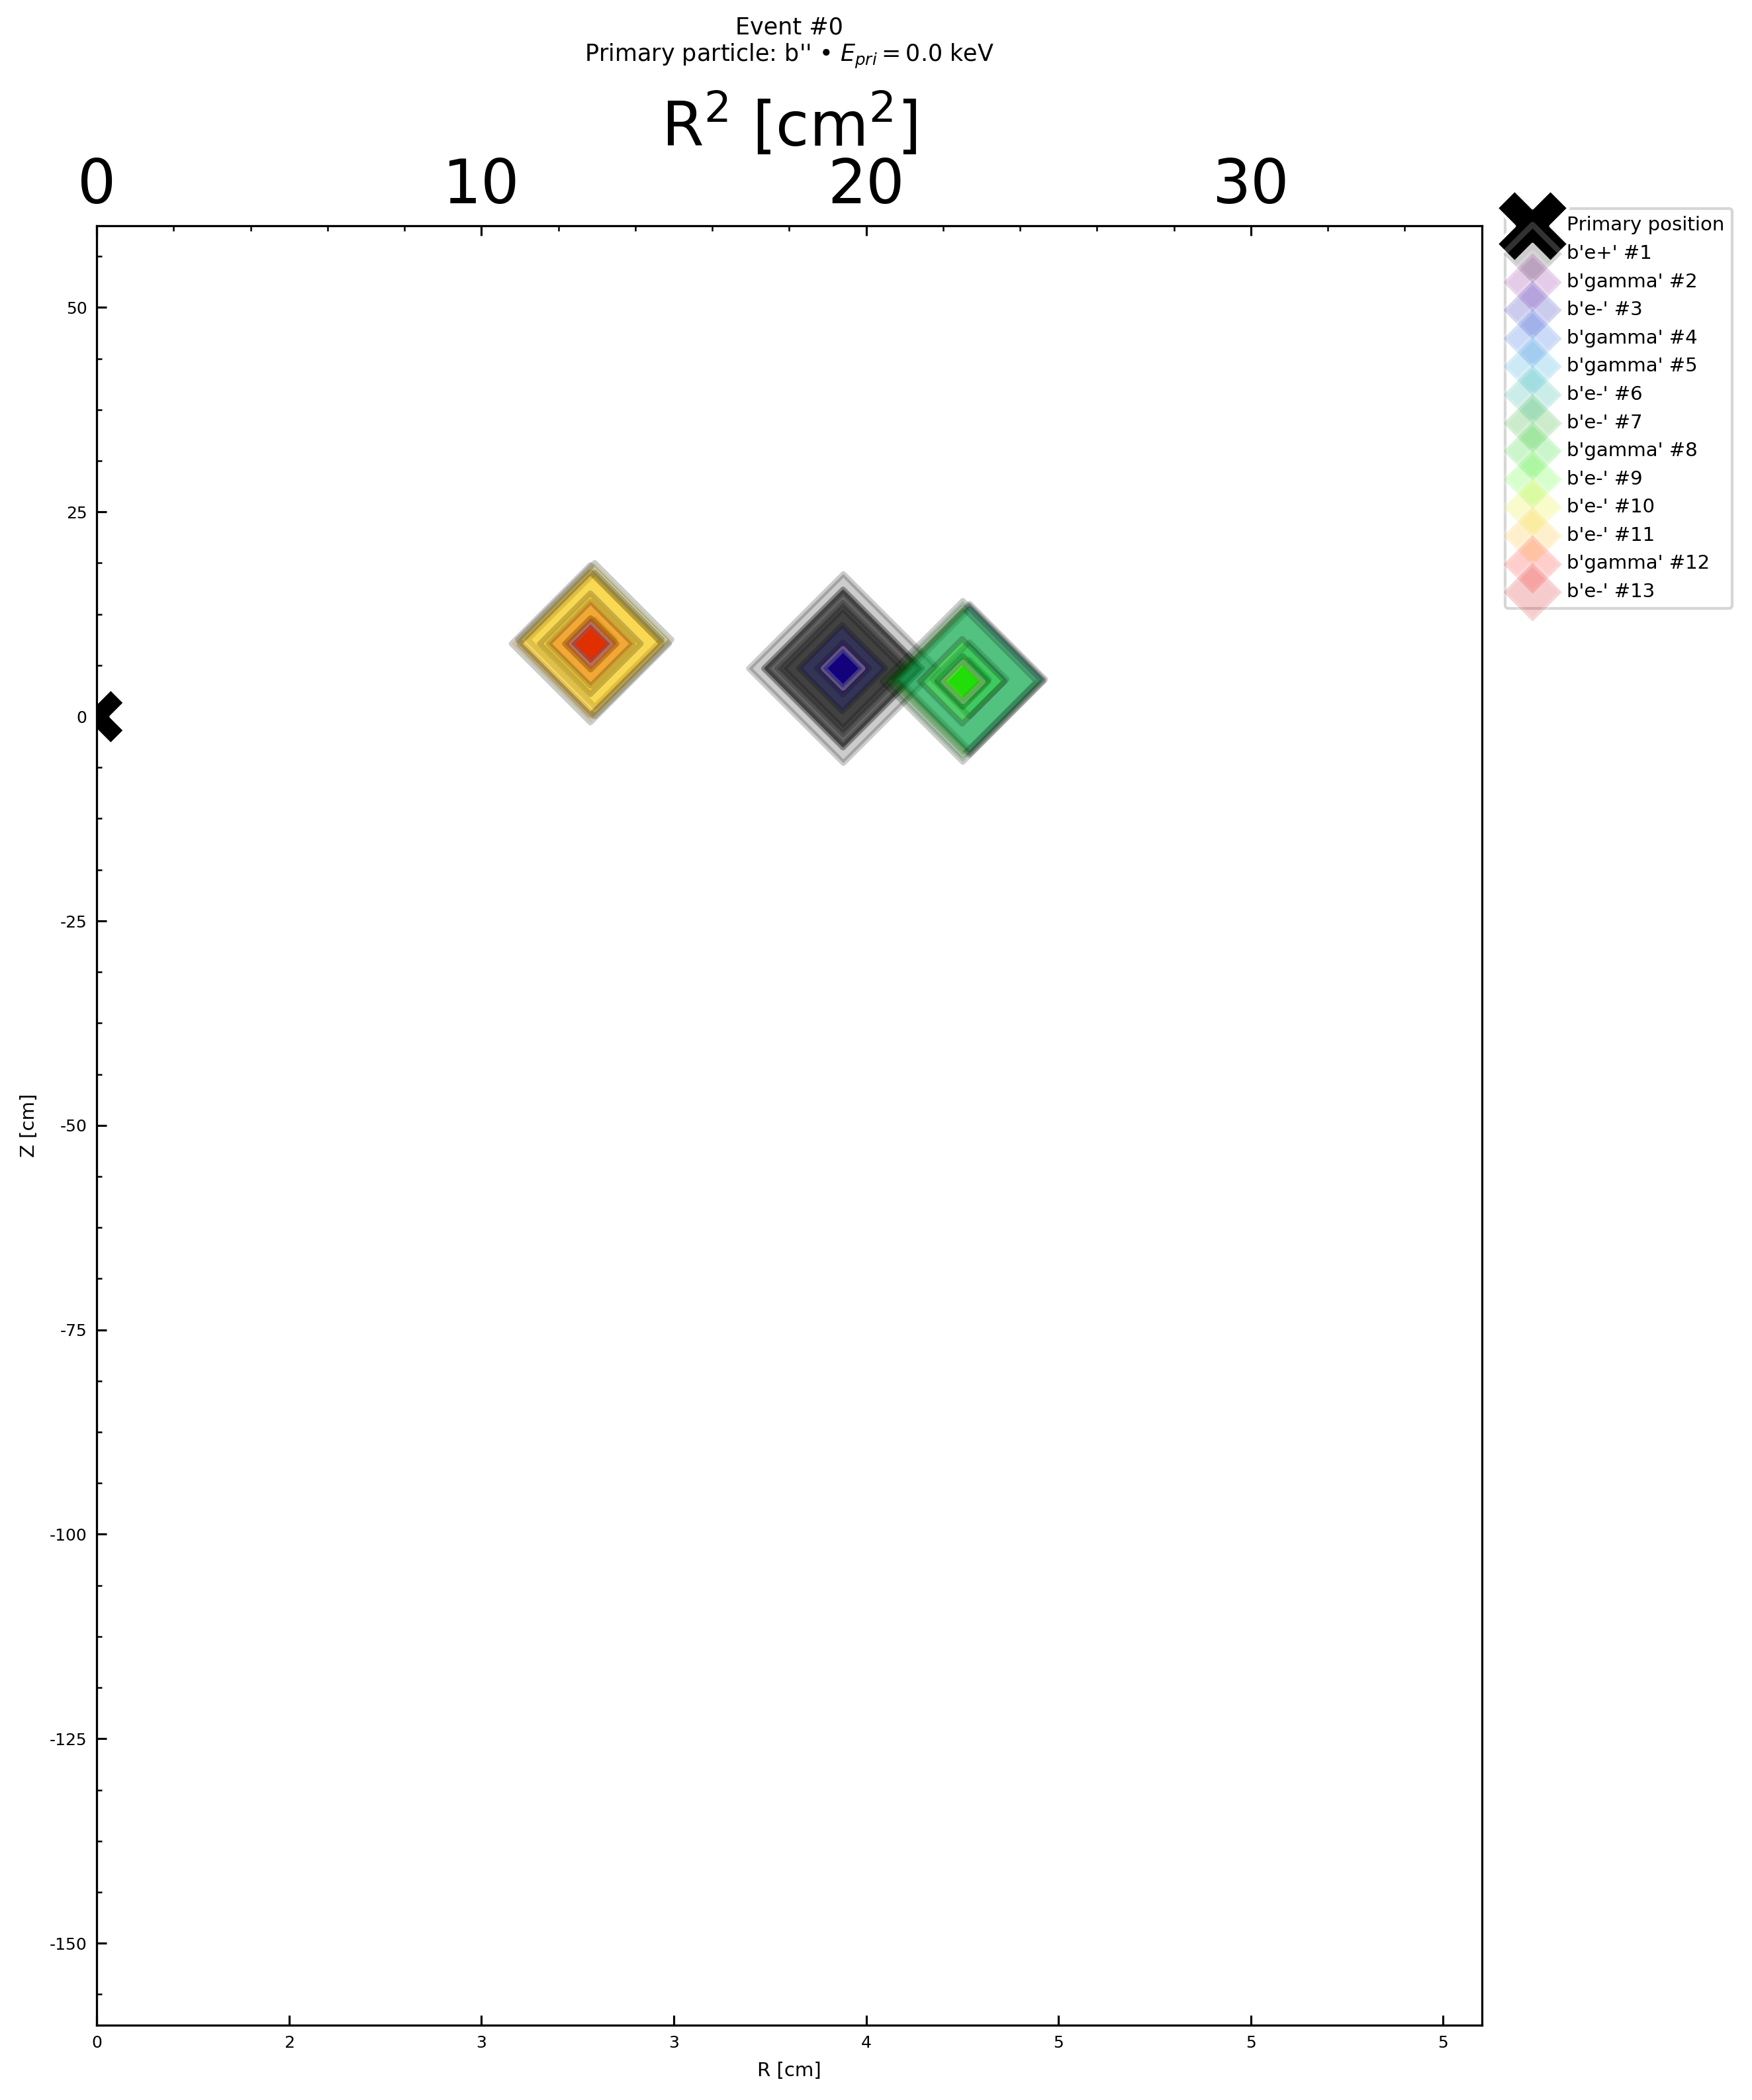

In [41]:
eventid = 0

#particles2show = ['neutron', 'gamma', 'e-', 'e+']
particles2show = []
particles2show = []

#----------------- Set of physical process to be labeled in the event display ----------------
'''Only these processes will be labeled.'''
processes2show = ['phot', 'compton', 'ionIoni', 'RadioactiveDecay'] # you may want to label different processes depending on the kind of simulation
#processes2show = []

event_display_rz(df, 
                 eventid, 
                 particles=particles2show, 
                 processes=processes2show,
                 xrange=(0,6), 
                 #yrange=(-60,60),
                 plot_hierarchy=False, hierarchy_subset=False, 
                 scan=False, 
                 savefig=False)